In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator
import seaborn as sns
from itertools import combinations, combinations_with_replacement
from collections import defaultdict
from diversity import Metacommunity

rng = np.random.default_rng(123) # 123 is the seed
%matplotlib notebook

In [2]:
def similarity(a, b, k=0.2):
    diff = abs(a-b)
    return np.exp(-k*diff)

In [3]:
def make_counts(communities, bin_count):
    d = {}
    for i, name in enumerate(communities.keys()):
        pop = communities[name]
        d[name] = np.histogram(pop, bins=bin_count, range=(0,100))[0]
    counts = pd.DataFrame(d)
    return counts

In [4]:
def show_viewpoint_curves(counts, 
                          k                       = 0.2,  # for similarity
                          show_without_similarity = True, 
                          show_with_similarity    = True,
                          figsize                 = None,
                          colors                  = ("black", "#999"),
                          s                       = 2,
                          qmin                    = 0,
                          qmax                    = 10,   # not counting infinity!
                          n_qs                    = 100,  # total number of qs
                          tau                     = "99",
                         ):

    # re-defining similarity here to pass k
    def similarity(a, b, k=k):
        diff = abs(a-b)
        return np.exp(-k*diff)
    
    # set q
    viewpoints = np.linspace(qmin, qmax, n_qs).tolist() + [np.inf]
    finite_viewpoints = viewpoints[:-1]

    parameters = []
    if show_without_similarity:
        if tau != "": tau = r", $\tau$=" + f"{tau}%"
        parameters.append(("$D_q$" + tau, False))
    if show_with_similarity:
        parameters.append(("     $D^Z_q$", True))
    results_dict = {}
    for name, flag in parameters:
        if flag:
            m = Metacommunity(counts,
                similarity=similarity,
                X=counts.index)
        else:
            m = Metacommunity(counts)
        div = m.to_dataframe(viewpoint=viewpoints)
        div.set_index(["community", "viewpoint"], inplace=True)
        results_dict[name] = div
    subplot_count = 3*len(parameters)
    
    # figsize
    width_ratios = [1, 0.1, 0.15] * len(parameters)
    width_ratios[-1] = 0.00001
    if figsize is None:
        figsize = (4*len(parameters),4)
    fig, ax = plt.subplots(1, subplot_count, 
                           figsize=figsize, 
                           width_ratios=width_ratios)
    fig.subplots_adjust(wspace=0.05)
    
    # actual plot
    for i, name in enumerate(results_dict.keys()):
        axis_index = i * 3
        ymax = 5
        div = results_dict[name]
        for j, label in enumerate(counts.columns):
            if i == 0:
                fig_label = label
            else:
                fig_label = None
            y_values = [div.loc[(label, q), "normalized_alpha"] for q in finite_viewpoints]
            ax[axis_index].scatter(finite_viewpoints, y_values, s=s, label=fig_label, color=colors[j])
            ax[axis_index+1].scatter([0.5], [div.loc[(label, np.inf), "normalized_alpha"]], s=s, color=colors[j])
            ymax = max(ymax, max(y_values))
        ymax *= 1.2
        
        # cosmetics
        ax[axis_index].grid(axis="y", lw=0.5, alpha=0.5, zorder=-1000)
        ax[axis_index+1].grid(axis="y", lw=0.5, alpha=0.5, zorder=-1000)
        if show_without_similarity:
            ax[axis_index].set_title(name)
        ax[axis_index].set_xlabel("$q$")
        ax[axis_index].margins(x=0.07)
        ax[axis_index].set_ylim([0, ymax])
        ax[axis_index+1].set_ylim([0, ymax])
        ax[axis_index].spines.right.set_visible(False)
        ax[axis_index+1].spines.left.set_visible(False)
        ax[axis_index+1].yaxis.tick_right()
        # ax[axis_index+1].set_yticks([])
        ax[axis_index+1].tick_params(length=0, width=0)
        ax[axis_index+1].set_yticklabels([])
        ax[axis_index+1].set_xticks([0.5], labels=['$\infty$'])
        # Adapted from https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
        d = 2  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax[axis_index].plot([1, 1], [0, 1], 
                                   transform=ax[axis_index].transAxes, **kwargs)
        ax[axis_index+1].plot([0, 0], [0, 1], 
                                transform=ax[axis_index+1].transAxes, **kwargs)
        ax[axis_index+2].spines.right.set_visible(False)
        ax[axis_index+2].spines.left.set_visible(False)
        ax[axis_index+2].set_visible(False)
    ax[0].set_ylabel("Effective no. of species")
    plt.subplots_adjust(bottom=0.2)

    fig.show()

In [5]:
outdir = "metagenomics_outdir/"

if not os.path.isdir(outdir):
    os.mkdir(outdir)

# Fig. 4a-b

Two samples of different types of diversity.

In [6]:
communities = {}

# mus are between 0 and 100 to facilitate "OTU" threshold in percent
group_mus_1 = [    16,             30,             42,     72, 88]     # the mean x value for each group
group_mus_2 = [14, 17, 20, 23, 27, 30, 32, 35, 38, 42]
sd_1 = 0.6
sd_2 = 0.6
n = 1000
communities["1"] = np.concatenate([rng.normal(mu, sd_1, int(n/len(group_mus_1))) for mu in group_mus_1])
communities["2"] = np.concatenate([rng.normal(mu, sd_2, int(n/len(group_mus_2))) for mu in group_mus_2])

<IPython.core.display.Javascript object>


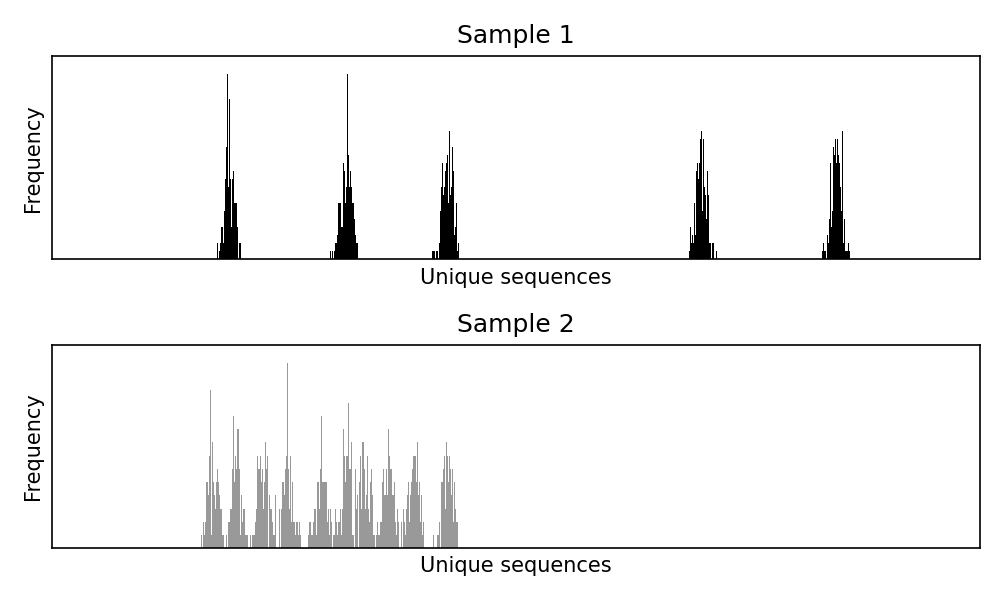

In [7]:
bin_count = 1000  # each bin here is interpreted as a *sequence*; these are histogram bins, not tau bins
figsize = (8*0.836, 2*len(communities))   # multiplier is to get the width the same as Fig. 4c-e
colors = ("black", "#999")
fig, axs = plt.subplots(len(communities.keys()), 1, figsize=figsize, sharex=True)#, sharey=True)
for i, name in enumerate(communities.keys()):
    ax = axs[i]
    heights = ax.hist(communities[name], bins=bin_count, range=(0,100), color=colors[i])[0]
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    ax.set_title(f"Sample {i+1}") #, ha='left', x=-0)
    ax.set_ylim(0, 1.1*np.max(heights))
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Unique sequences")
plt.tight_layout()
plt.show()
plt.savefig(outdir + "metagenomics_fig4ab.pdf")

# Fig. 4c-e

Fig. 4e is reproduced twice below; so the panels go 4c, 4e and then 4d, 4e.

2023-11-25 17:52:39,163	INFO worker.py:1553 -- Started a local Ray instance.


<IPython.core.display.Javascript object>


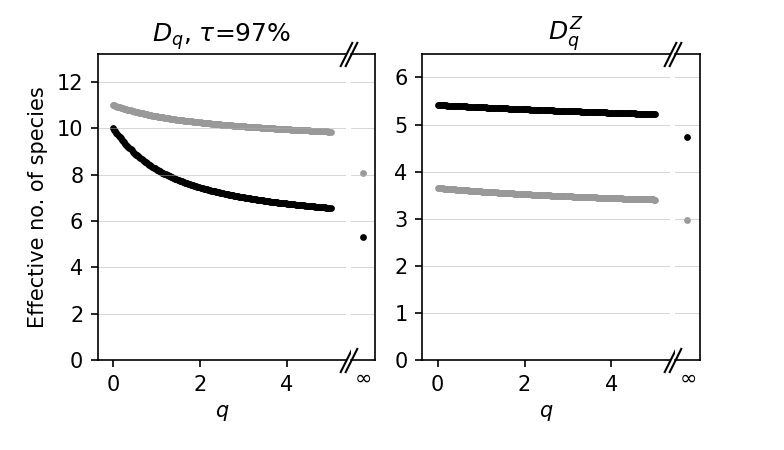

In [8]:
bins = 33
counts = make_counts(communities, bins)
show_viewpoint_curves(counts, 0.2*100/bins, True, True, figsize=(8*2/3/1.02,3), s=5, qmax=5, n_qs=200, tau="97")
plt.savefig(outdir + "metagenomics_fig4c.pdf")

<IPython.core.display.Javascript object>


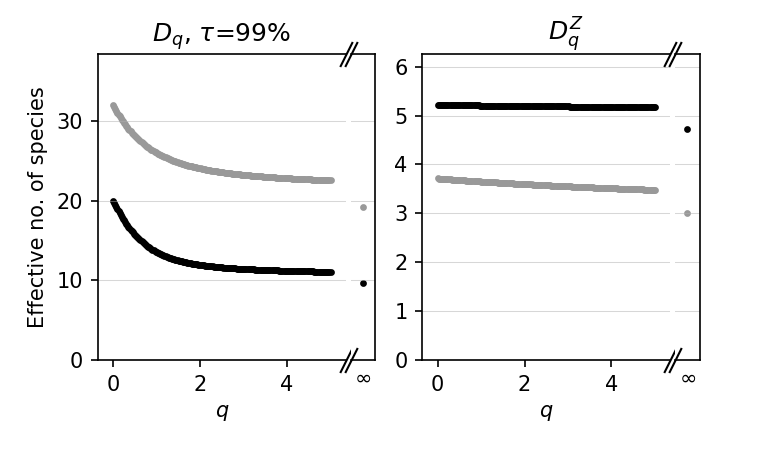

In [9]:
bins = 100
counts = make_counts(communities, bins)
show_viewpoint_curves(counts, 0.2*100/bins, True, True, figsize=(8*2/3/1.02,3), s=5, qmax=5, n_qs=200, tau="99")
plt.savefig(outdir + "metagenomics_fig4de.pdf")

<IPython.core.display.Javascript object>


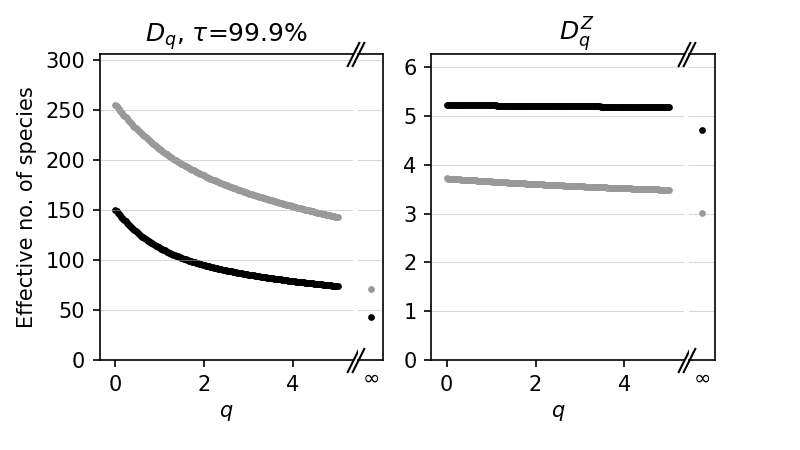

In [10]:
bins = 1000
counts = make_counts(communities, bins)
show_viewpoint_curves(counts, 0.2*100/bins, True, True, figsize=(8*2/3,3), s=5, qmax=5, n_qs=200, tau="99.9")

# Fig. 5a

Nine samples from three enterotypes.

In [11]:
communities = {}

dominant_mus = [25, 50, 67]
minor_mus    = [10, 20, 25, 33, 40, 50, 60, 67, 80, 90]

tot_seqs = 1000
n_per_enterotype = 3
ratio = 4  # ratio of dominant to any minor population
sd    = 2

# add sequences for dominant enterotype
for i, dominant_mu in enumerate(dominant_mus):
    for j in range(n_per_enterotype):
        community_name = f"{i+1}-{j+1}"
        community = []
        n_to_add = int(round((ratio-1)*n/len(minor_mus))) # ratio-1 b/c dom is also added as a minor_mu below
        community += list(rng.normal(dominant_mu, sd, n_to_add))
        communities[community_name] = community
        
# add sequences for minor enterotypes
for community_name, community in communities.items():
    for minor_mu in minor_mus:
        n_to_add = int(round(n/len(minor_mus)))
        community += list(rng.normal(minor_mu, sd, n_to_add))
        communities[community_name] = community

<IPython.core.display.Javascript object>


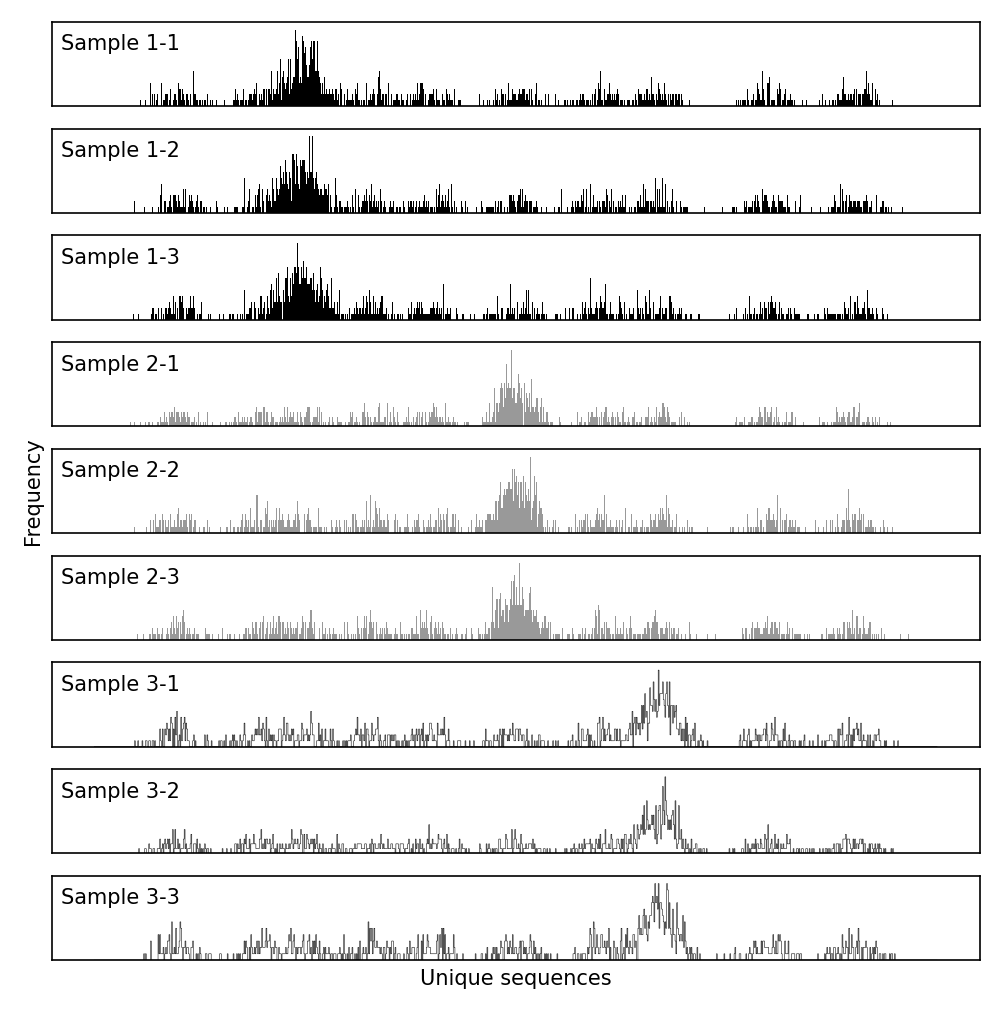

In [12]:
bin_count = 1000   # each bin here is interpreted as a *sequence*; these are histogram bins, not tau bins
figsize = (8*0.836, 0.75*len(communities))   # multiplier is to get the width the same as Fig. 4c-e
colors = ["black",]*3 + ["#999",]*3 + ["black",]*3
histtypes = ["bar",]*6 + ["step",]*3
fig, axs = plt.subplots(len(communities.keys()), 1, figsize=figsize, sharex=True)#, sharey=True)
for i, (community_name, community) in enumerate(communities.items()):
    ax = axs[i]
    heights = ax.hist(community, bins=bin_count, range=(0,100), 
                      color=colors[i], histtype=histtypes[i], lw=0.25)[0]
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    xmin, xmax = ax.get_xlim()
    ymax = ax.get_ylim()[1]
    xloc = xmin+(xmax-xmin)*0.01
    yloc = ymax*0.7
    ax.text(xloc, yloc, "Sample " + community_name)
    # ax.set_title(f"Sample {community_name}") #, ha='left', x=-0)
    ax.set_ylim(0, 1.1*np.max(heights))
    if i == int(round((len(communities)-1)/2)): ax.set_ylabel("Frequency")
    if i == len(communities)-1: ax.set_xlabel("Unique sequences")
plt.tight_layout()
plt.show()
plt.savefig(outdir + "metagenomics_fig5a.pdf")

In [13]:
def pairwise_heatmap(
                    communities, 
                    q=0,
                    k=0.02,
                    bins=100,
                    vmin = None, vmax = None,
                    figsize=(3,3), 
                    symmetric=False, 
                    with_similarity=True, 
                    filename=None,
                    cmap="bone_r",
                    ):

    # re-defining similarity here to pass k
    def similarity(a, b, k=k):
        diff = abs(a-b)
        return np.exp(-k*diff)
        
    comparisons = defaultdict(dict)
    population_names = list(communities.keys())
    for a, b in combinations_with_replacement(communities.keys(), 2):
        if a == b:
            counts = pd.DataFrame({
                a : np.histogram(communities[a], bins=bins, range=(0,100))[0],
                (a+"_") : np.histogram(communities[a], bins=bins, range=(0,100))[0], 
            })
        else:
            counts = pd.DataFrame({
               a : np.histogram(communities[a], bins=bins, range=(0,100))[0],
               b : np.histogram(communities[b], bins=bins, range=(0,100))[0],
            })
        if with_similarity:
            metacommunity = Metacommunity(counts,
                            similarity=similarity,
                            X=counts.index)
        else:
            metacommunity = Metacommunity(counts)
        div = metacommunity.to_dataframe(viewpoint=[q])
        div.set_index(["community", "viewpoint"], inplace=True)
        if symmetric:
            value = div.loc[("metacommunity", 0), "rho"]
            comparisons[a][b] = value
            comparisons[b][a] = value
        else:
            value = div.loc[(a, 0), "rho"]
            comparisons[a][b] = value
            value = div.loc[(b, 0), "rho"]
            comparisons[b][a] = value

    columns = {}
    for name in population_names:
        columns[name] = []
        for other in population_names:
            rho = comparisons[name][other]
            columns[name].append(rho)
    heatmap = pd.DataFrame(columns, index=population_names)
    g = sns.clustermap(data=heatmap, cmap=cmap, figsize=figsize, vmin=vmin, vmax=vmax)
    if symmetric:
        adverb = "metacommunity"
    else:
        adverb = ""
    if filename is not None:
        plt.savefig(outdir + filename)
    plt.show()
    return

<IPython.core.display.Javascript object>


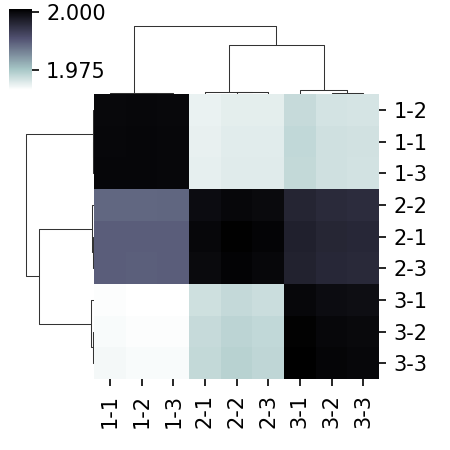

/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \
/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \


In [14]:
bins = 1000
pairwise_heatmap(communities, k=0.2*100/bins, filename="metagenomics_fig5b.pdf")

<IPython.core.display.Javascript object>


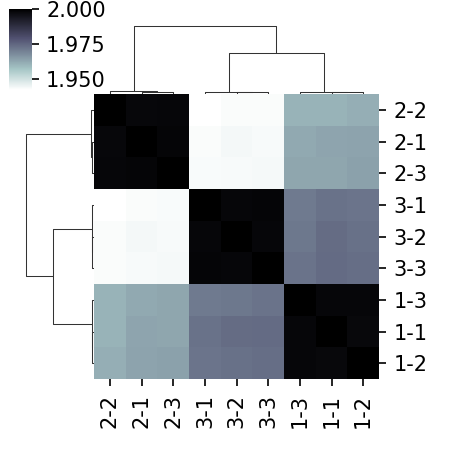

/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \
/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \


In [15]:
bins = 1000
pairwise_heatmap(communities, k=0.2*100/bins, bins=bins, symmetric=True, filename="metagenomics_fig5c.pdf")

<IPython.core.display.Javascript object>


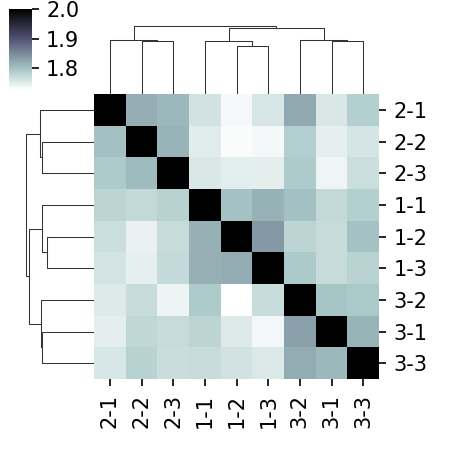

/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \
/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \


In [16]:
pairwise_heatmap(communities, bins=1000, with_similarity=False, filename="metagenomics_fig5d.pdf")

<IPython.core.display.Javascript object>


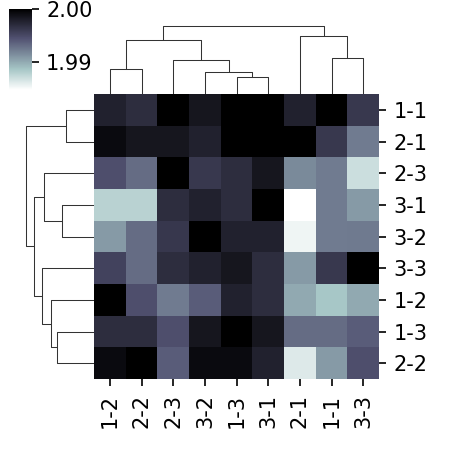

/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \
/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/fastcluster.py:26: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  from numpy import double, empty, array, ndarray, var, cov, dot, bool, \


In [17]:
pairwise_heatmap(communities, bins=100, with_similarity=False, filename="metagenomics_fig5e.pdf")

In [18]:
import matplotlib
matplotlib.rc_file_defaults()